<img src="download1.png" width="400" height="400" align="center"/>

***Table of Contents:***

- [Understanding the Problem and Objective](#Understanding-the-Problem-and-Objective)


- [Reading from Data Sources](#Load-train-and-test-files)


- [Base Algorithm](#Build-a-Quick-Baseline-model)


- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    
    - [Data Overview](#Data-Overview)
    - [Imbalanced Dataset](#Imbalanced-Dataset)
    - [Feature Selection](#Feature-Selection)
    - [Correlations](#Feature-Correlation)
    - [Feature Importance](#Feature-Importance)
    - [Distribution of Features in Train and Test Sets](#Distribution-of-Features-in-Train-and-Test-Sets)
    - [Probability of Transaction](#Probability-of-Transaction)


- [Feature Engineering & Preprocessing the Data](#Feature-Engineering-&-Preprocessing-the-Data)


- [Final Algorithm](#Modeling)


- [Questions](#Questions)

    - [How are you avoiding overfitting and underfitting?](#How-are-you-avoiding-overfitting-and-underfitting?)
    - [What cleansing steps did you need to take, if any?](#What-cleansing-steps-did-you-need-to-take,-if-any?)
    - [What techniques did you use to choose your features?](#What-techniques-did-you-use-to-choose-your-features?)
    - [What are some downsides to not knowing what the variables mean. What are some upsides?](#What-are-some-downsides-to- not-knowing-what-the-variables-mean.-What-are-some-upsides?)
    - [Kernels and Discussions that I reviewed](#Kernels-and-Discussions-that-I-reviewed)

## Understanding the Problem and Objective

Santander has provided us a dataset with 200 descriptive features. Our objective is to create a predictive model that will help us identify which customers are going to make a transaction in the future.

## Load train and test files

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split #for creating a validation set
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv("../input/train.csv") #read the train file
Y = train['target'] # store the target variable

test = pd.read_csv("../input/test.csv") #read the test file

### Data Overview

In [5]:
print ("Train shape: " + str(train.shape))
print ("Test shape: " + str(test.shape))

Train shape: (200000, 202)
Test shape: (200000, 201)


In [6]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


**Check for missing values**

In [8]:
print ("Number of missing columns in train set: " + str(sum([col for col in train.columns if train[col].isnull().any()])))
print ("Number of missing columns in test set: " + str(sum([col for col in test.columns if test[col].isnull().any()])))

Number of missing columns in train set: 0
Number of missing columns in test set: 0


We see that there are 200,000 instances/objects in both training and test sets. The dataset also contains 200 features. We can see that the data is anonymized which will make it harder for us to gain intuition about the data; it contains all numeric values with no missing values. 

## Build a Quick Baseline model

In our first baseline model, we are going to include all 200 features. We are going to split the train set into training and validation sets and measure the performance of our model on our validation set using AUROC. We will try 3 ensemble machine learning models--Gradient Boosting, Random Forest, and CatBoost-- to see which model performs better. 

**Reason for selecting Boosting:** More powerful than a single model since predictions are based on multiple models in the ensemble, builds sequentially by increasing weights on the instances misclassified by the previous learner, which reduces variance and bias. 

In [9]:
X = train.copy() #create a copy of the training set to keep the train data intact
X.drop(['target','ID_code'], axis = 1, inplace = True) #drop the target and ID_code columns from the training set

#splitting the training data in train (80%) and validation sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

# initialize the classifier and train
clf = CatBoostClassifier(logging_level = 'Silent').fit(X_train.values, y_train.values) 
roc_auc_score(y_test.values, clf.predict_proba(X_test)[:,1]) #AUROC of the validation set

0.8950248823221514

**Model Comparison**

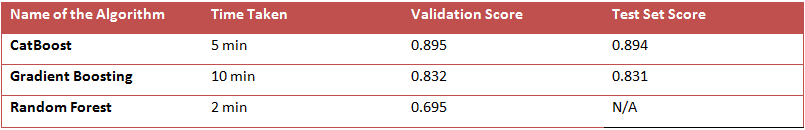

In [1]:
from IPython.display import Image
Image(filename='Desktop/santander-customer-transaction-prediction/MLalg.png') 

We notice that even without doing any EDA, feature engineering, hypertuning the parameters, we achieve an AUROC of 0.894. 

Since we do not want to suffer from the curse of dimensionality, we will reduce the number of features in our model by including the features that play a significant role in determining the target variable.

We will have to now explore the data to better understand the data and build intuition. Along the way, we will generate and test our hypotheses and find insights through visualizations.

## Exploratory Data Analysis

Let's see what proportion of people carried out a transaction. Since its a binary classification problem, we have to take into account imbalanced dataset.

0    89.951
1    10.049
Name: target, dtype: float64


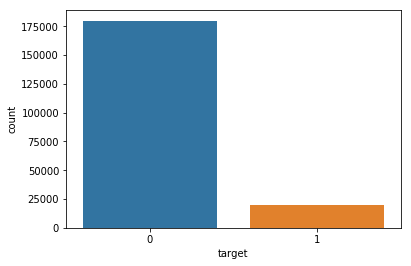

In [10]:
print(train.target.value_counts(normalize = True) * 100) #what percentage is 0 and 1.
sns.countplot(train.target)

We see that the class is imbalanced. We can apply the SMOTE algorithm to oversample the minority class, and fit our model on the new objects created. *[We will do this later]*

### Feature Selection

### Feature Correlation

Let's see how strongly is each variable correlated to all the other variables.

[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'correlation coefficient')]

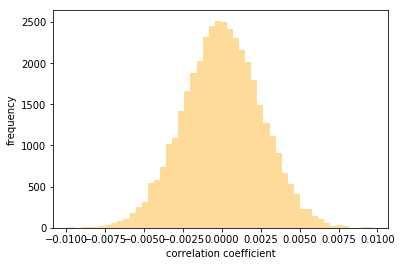

In [11]:
correlation_matrix = train.corr() #create a correlation matrix where value in each cell denotes the correlation coefficient
correlations_array = correlation_matrix.iloc[1:201,1:201].values.flatten() #turn to 1-D np array so seaborn can plot it
correlations_array = correlations_array[correlations_array != 1]
ax = sns.distplot(correlations_array, kde = False, color = 'Orange') #plot the histogram
ax.set(xlabel='correlation coefficient', ylabel='frequency') #set labels

We can see that all variables are uncorrelated with each other as a large part of the histogram is concentrated near 0.

Let's see how the features are correlated to target.

[Text(0, 0.5, 'frequency'),
 Text(0.5, 0, 'correlation of variables with target')]

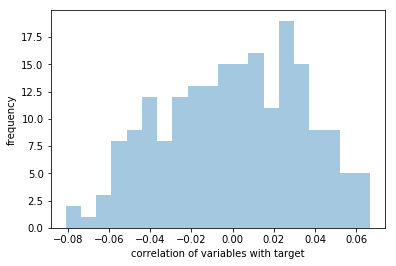

In [12]:
correlation_with_target = train.corr().loc[:,'target'][1:] #get the correlation coefficient of each variable with target var
axi = sns.distplot(correlation_with_target.values,bins = 20, kde = False) #plot the histogram
axi.set(xlabel='correlation of variables with target', ylabel='frequency') #set label

Again, the variables are not correlated with target. (The highest correlation coefficient is 0.066 with var_6.)

### Feature Importance

We will get the feature importance from the baseline model we trained.

In [13]:
feat_imp = {}
var = 0
for i in clf.feature_importances_:
    feat_imp[var] = i
    var += 1
    
#create a dataframe containing the feature importance score of each variable    
feat_imp_df = pd.DataFrame(list(feat_imp.values()), index = ['var_' + str(i) for i in range(200)], 
                           columns = ['Feature_importance'])

feat_imp_df.T

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Feature_importance,1.154472,1.003318,1.144063,0.105005,0.143881,0.620536,1.695182,0.041428,0.192609,0.854675,0.023709,0.299418,1.648851,1.167744,0.014434,0.166845,0.073015,0.02628,0.777601,0.152149,0.310179,1.308274,1.365738,0.400234,0.450616,0.059056,1.422848,0.056971,0.366989,0.036078,0.044523,0.28184,0.5305,0.903357,1.093078,0.617514,0.627276,0.034449,0.028003,0.024698,...,0.040323,0.02839,0.559434,0.597617,0.889479,1.179587,1.318192,0.438375,0.227824,0.904165,1.049981,0.172144,0.648258,0.798582,1.301836,0.351084,0.046182,0.821526,0.218009,0.974489,0.630057,0.131554,0.054119,0.041331,0.980924,0.04277,0.432424,0.248202,0.615162,0.085315,1.080026,0.872683,0.763945,0.208015,0.251294,0.44346,0.333898,0.615808,1.129264,0.404579


In [14]:
feat_imp_df.nlargest(5,'Feature_importance') #display top 5 with the greatest value

,Feature_importance
var_81,2.418249
var_139,1.859719
var_6,1.695182
var_12,1.648851
var_53,1.552341


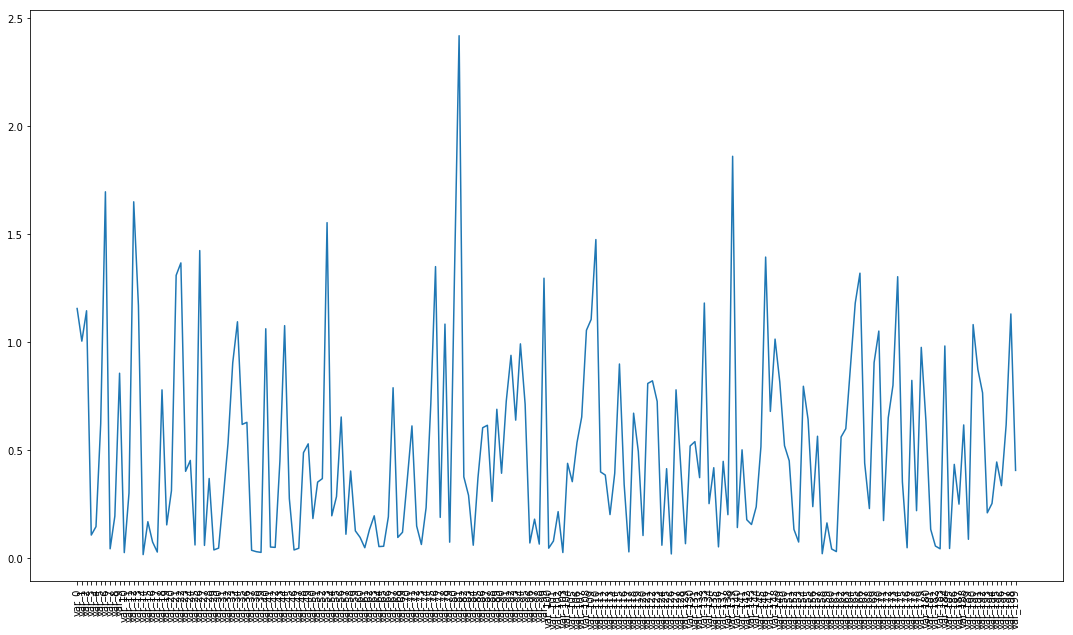

In [15]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(clf.feature_importances_)
plt.xticks(np.arange(200), X.columns.tolist(), rotation=90);

In [ ]:
# X1 = train.copy() #make another copy to run on our 2nd baseline model
# X1.drop(['target','ID_code'], axis = 1, inplace = True) #as usual, drop the target and ID_code column
# X1.drop(feat_imp_df.feature_importance.nsmallest(35).index, axis = 1, inplace = True) #drop 35 columns with lowest FI score

# #splitting the training data in train (80%) and validation sets (10%)
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y, test_size = 0.20, random_state = 42)

# # initialize the classifier and fit it to our set
# clf = CatBoostClassifier(logging_level = 'Silent', eval_metric = 'AUC').fit(X1_train.values, y1_train.values) 
# roc_auc_score(y1_test.values, clf.predict_proba(X1_test)[:,1]) #AUROC on our validation set

After dropping the features with the least feature importance score, I trained another model containing the top 165 features. However, that model did not perform well on the training set. Therefore, I'll keep all the features when training the model.

### Distribution of Features in Train and Test Sets

It is crucial to understand the generation process of train and test sets. If both sets are different, then we cannot use the train set because it will not be representative of test set. Therefore, we cannot evaluate our models using it.

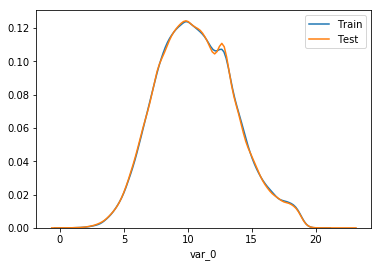

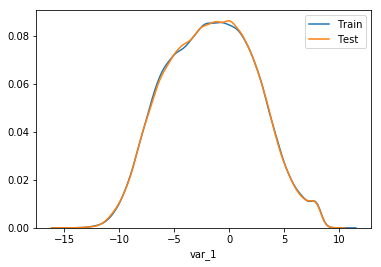

<Figure size 432x288 with 0 Axes>

In [16]:
"""This function plots the density curve of 0's (~purchase) and 1's (purchased) for the given feature"""
def plotDensity(df, var):
    ones = df.loc[df.target == 1, var] #get only the people who made a transaction
    zeros = df.loc[df.target == 0, var] #get only the people who did not make a transaction
    sns.distplot(ones, hist = False, label = '1')
    sns.distplot(zeros, hist = False, label = '0')
    plt.figure()
   
for i in range(2):
    sns.distplot(train['var_' + str(i)], hist = False, label = 'Train')
    sns.distplot(test['var_' + str(i)], hist = False, label = 'Test')
    fig = plt.figure()

After looking at all the plots, it is clear that the train and test sets come from the same distribution.

### Probability of Transaction

In [17]:

""" This function returns a dataframe containing the people who carried out a transaction in each bin """
def binning(variable, df, bin_count = 50):
    #create a new column that states the bin each instance belongs to
    df['bin'] = pd.cut(df[variable], bins = bin_count)
    
    #extracts the bin where the target is 1, gets the total count of each bin, and sort the bin values in asc order
    a = pd.DataFrame(df.loc[df.target == 1, ['bin']].bin.value_counts().reset_index().sort_values('index'))
    
    #rename the columns
    a.rename(columns = {'index':'Bin', 'bin':'Purchased'}, inplace = True)
    
    #extracts the bin where the target is 1, gets the total count of each bin, and sort the bin values in asc order
    b = pd.DataFrame(df.loc[df.target == 0, ['bin']].bin.value_counts().reset_index().sort_values('index'))
    b.rename(columns = {'index':'Bin', 'bin':'Did Not Purchase'}, inplace = True)
    
    #drop bin column to keep training set intact
    df.drop(['bin'], axis = 1, inplace = True) 
    
    #inner join tables a and b on Bin
    bin_table = pd.merge(a,b,how='inner')
    
    #total number of people in each bin
    bin_table['Total'] = bin_table['Purchased'] + bin_table['Did Not Purchase']
    #how many people in each bin carried out a transaction
    bin_table['Purchased %'] = bin_table['Purchased']/bin_table['Total']
    #give each bin a bin number
    bin_table['Bin_num'] = np.arange(bin_count)
    #fill any NA values with 0
    bin_table['Purchased %'].fillna(0, inplace = True)
    
    return bin_table

"""
 This function plots bins vs the frequency of people who made a transaction and did not make a transaction in that bin. 
 Furthermore, it also plots the probability of a transaction in each bin.
 """
    
def plotting(bin_table):
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    plot1 = bin_table.plot(x = 'Bin_num' , y = 'Purchased %', kind = 'line', 
                           ylim = (0,bin_table['Purchased %'].max() + 0.03),
                           title = "Probability of transaction in each bin", colormap = 'RdBu', ax = ax[0])
    plot1.set_ylabel("Probability")
    
    plot2 = bin_table.plot(x = 'Bin_num', y = ['Did Not Purchase', 'Purchased'], kind = 'line', 
                           ylim = (0,bin_table['Did Not Purchase'].max() + 200), 
                           title = "Frequency in each bin", ax = ax[1])
    plot2.set_ylabel("Number of People")

var_0
var_1


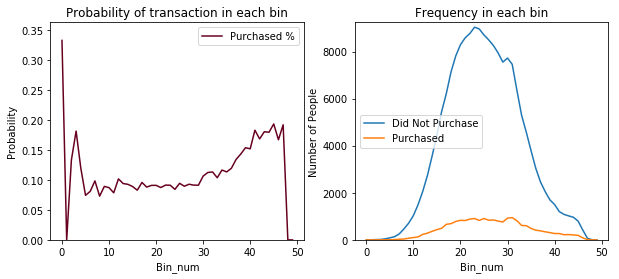

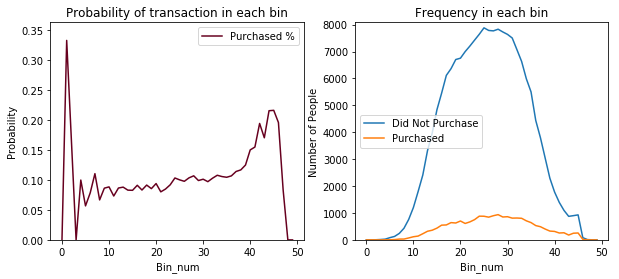

In [18]:
ngraph = 2 #number of graphs we want to plot
for i in range(ngraph):
    print('var_' + str(i))
    plotting(binning('var_' + str(i), train))

By looking at var_0 graph, we notice that people in early bins (0-8) and bins at the end (30-48) have a higher probability to make a transaction on average than the people in the middle bins (9-30). The same is true for var_1.

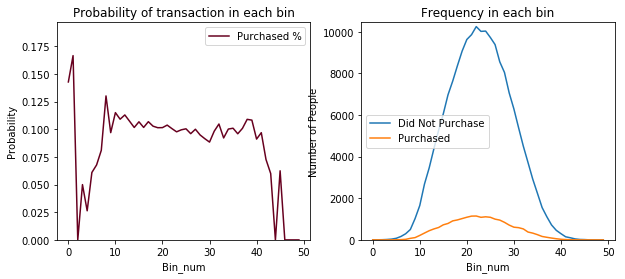

In [19]:
plotting(binning('var_120', train))

In this graph, the people in the middle bins are more likely to make a purchase. Our machine learning model might be able to capture these patterns from the graphs based on the new features we create.

## Feature Engineering & Preprocessing the Data

**Aggregrate**

Creating a new feature by taking row sum and then normalizing it.

In [20]:
X_train = train.copy() #create a copy of the training set
X_test = test.copy() #create a copy of test set for training the model

fullData = [X_train,X_test] #contains train and test sets copies

X_train.drop(['target','ID_code'], axis = 1, inplace = True) #drop these features
X_test.drop(['ID_code'], axis = 1, inplace = True)

#Preprocess the data
for df in fullData:
    df['addition'] = df.sum(axis = 1) #calculate the sum across the rows
    df["newadd"] = df['addition'].apply(lambda x: (x - df['addition'].mean()) / df['addition'].std()) #normalize it
    df.drop(['addition'], axis = 1, inplace = True) #drop the addition column

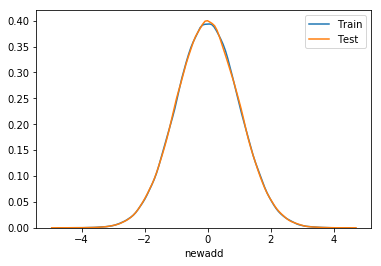

In [21]:
#plot the distribution of new feature
sns.distplot(X_train['newadd'],hist = False, label = 'Train')
sns.distplot(X_test['newadd'], hist = False, label = 'Test')

We can see that by normalizing the newadd column the train and test sets have the same distribution.

**Binning**

In [22]:
"""Goes through each bin to check if the given value is in that bin's range, and then returns the probability"""   
def fillProb(dataf, var_value):
    for i in range(len(dataf['Bin'])):
        if var_value in dataf['Bin'][i]:
            return (dataf['Purchased %'][i]) * 100
    return 0
    

"""returns  dataframe with new variable containing the Purchased %"""
X = train.copy() #stores the probability of training set
def fillData(var, dataframe = X):    
    b = binning(var,X)
    dataframe['new_' + str(var)] = dataframe[var].apply(lambda x: fillProb(b,x))
    return dataframe


In [23]:
#creating new features based on the probability of a transaction
for i in range(2):
    fillData('var_' + str(i)) 
    X_train['new_var_' + str(i)] = X['new_var_' + str(i)] #add probability column in train set
    fillData('var_' + str(i), X_test) #add probability column in test set

In [24]:
X_train.head() #checking if the new columns are created in train set
X_test.head() #checking if the new columns are created in test set

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,newadd,new_var_0,new_var_1
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,...,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,0.781906,8.966256,21.583986
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,...,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,-1.299114,9.115810,10.310717
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,0.8804,...,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,0.951667,10.195228,8.643457
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,8.8336,...,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,0.717143,9.115810,9.790291
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,0.3695,...,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0.870354,9.148085,9.917259


In [25]:
train['target'].corr(X_train['var_0'])
train['target'].corr(X_train['new_var_0'])

0.06828867348279034

We can see that the new variable create have a higher correlation to target than the old variable.

Now we are going to create synthetic examples of the minority class so that the algorithm can learn better.

** SMOTE (Oversampling the minority class) **

In [ ]:
#from imblearn.over_sampling import SMOTE

# X1 = train.copy() #create a copy of the training set
# X1.drop(['target','ID_code'], axis = 1, inplace = True)

# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y, test_size = 0.1, random_state = 42)

# sm = SMOTE(random_state=12, ratio = 0.75) #initialize the variable
# x_train_res, y_train_res = sm.fit_sample(X1_train, y1_train) #oversample the minority class to a ratio of 0.75:1

# clf = CatBoostClassifier().fit(x_train_res, y_train_res) #train on the synthetic samples
# print (roc_auc_score(y1_test.values, cl.predict_proba(X1_test)[:,1]))

Note: SMOTE did not improve the AUROC.

** Data Augmentation **

We are going to use data augmentation to increase the number of minority class in our dataset. This technique results in an increase in the model's performance.

In [26]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)
        
    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    
    return x,y

## Modeling

**Finding Hyperparameters**

In [ ]:
from sklearn.model_selection import GridSearchCV #for finding the best hyperparameters 

#carry out data augmentation

cat = CatBoostClassifier(loss_function = 'Logloss', 
                         iterations = 10000, 
                         task_type="GPU", 
                         early_stopping_rounds = 500, 
                         random_seed = 42)   

parameters = {'learning_rate' : [0.01,0.0728], 'depth' : [8,10]} #Parameters to test 

# clgs = GridSearchCV(cat, parameters, cv=2) #do an exhaustive search to find the best parameters
# clgs.fit(X1_train,y1_train)
# print (roc_auc_score(y1_test.values, clgs.predict_proba(X1_test)[:,1]))


We find that the best parameters for our model that results in highest AUROC is when learning rate = 0.01 & tree depth = 8.

**Training & Measuring Performance**

In [28]:
#get a validation set
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train, Y, test_size = 0.1, random_state = 42)

#apply data augmentation on training set (not on validation set)
x,y = augment(X1_train.values, y1_train.values)

# initialize the classifier
cb = CatBoostClassifier(loss_function = 'Logloss', iterations = 10000, learning_rate = 0.01, depth = 8,
                         logging_level = 'Silent', early_stopping_rounds = 500, random_seed = 42)   

#train on the augmented data
cb.fit(x,y) 
roc_auc_score(y1_test.values, cb.predict_proba(X1_test)[:,1])

0.9010478329251548

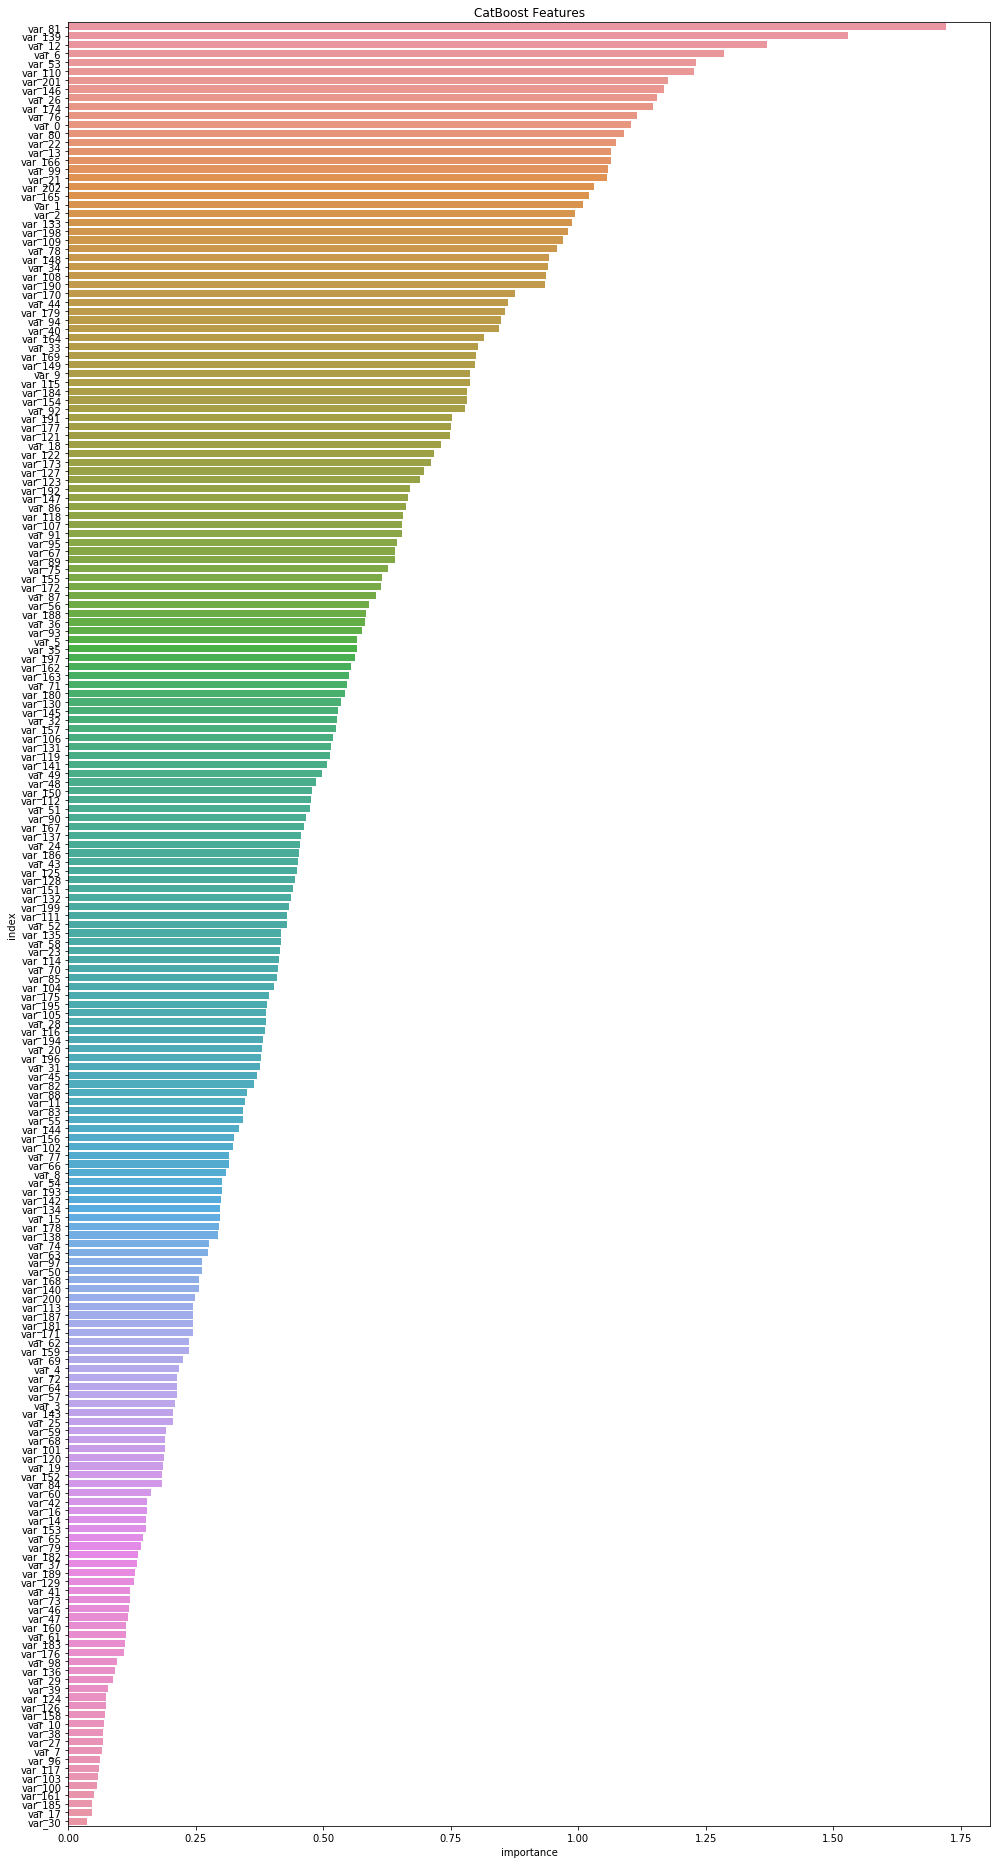

In [29]:
feat_impl = {}
var = 0
for i in cb.feature_importances_:
    feat_impl[var] = i
    var += 1
    
#create a dataframe containing the feature importance score of each variable    
feat_impl_df = pd.DataFrame(list(feat_impl.values()), index = ['var_' + str(i) for i in range(203)], 
                           columns = ['importance'])
feat_impl_df.reset_index(inplace = True)

plt.figure(figsize=(14,26))
sns.barplot(x = "importance", y = "index", data = feat_impl_df.sort_values(by="importance",ascending=False))
plt.title('CatBoost Features')
plt.tight_layout()

It is evident from this diagram that our created features rank high and therefore play a vital role in our model.

**Fit model on the test set**

In [30]:
X_train.shape == X_test.shape #checking if train and test sets have the same shape

True

In [ ]:
tID = test.ID_code

predictions = cb.predict_proba(X_test)
frame_gb = pd.DataFrame(predictions[:,1], columns = ['target'], index = tID)

## Questions

### How are you avoiding overfitting and underfitting?

Underfitting occurs when the model fails to learn the intricacies of the training data, resulting in a high error on the training data. This occurs because the machine learning model is too simple and also because the algorithm was not trained enough. To avoid underfitting, I used an **ensemble algorithm**, called Gradient Boosting, that contains 1000 trees in its ensemble, making the model sufficiently complex to capture the underlying trend in the training data. Since an underfitted model has a high bias, boosting can also reduce bias, making the model robust. I also constantly **monitored the AUROC** (the evaluation metric) to ensure that the model is in fact learning. In instances when AUROC is low, I increased the **number of iterations** so that the model can learn from the training data.

Overfitting occurs when the model memorizes the training set and fails to generalize to unseen examples, and as a result, the gap between the training error and test error is large. Trees in the ensemble tend to overfit as they get deeper because the nodes contain smaller and smaller subsets of objects and become fixated on the training data. To counteract this issue, I **set the maximum depth** of tree to 8 to avoid the trees from creating nodes around noisy data so they can generalize better. Hyperparameters play a vital role in determining the accuracy of a model. However, tuning the hyperparameters on the training data will result in overfitting because the parameters chosen are optimal for training data and will not necessarily work on unseen data. To avoid this problem, I trained my model on the training set, but chose the hyperparameters that gave a higher score on the **validation set**. I also set the **early stopping round** to 500, which avoids overfitting by attempting to automatically select the inflection point where performance on the validation data starts to decrease while performance on the training data continues to improve as the model starts to overfit.

### What cleansing steps did you need to take, if any?

As the data contained all numerical values and was carefully crafted, we did not encounter any data quality issues, such as dealing with outliers and missing values.

However, we still needed to clean data to make it more interpretable to our model. After creating a feature that calculated the sum across the rows, I **standardized the values** of that feature  so that it has a mean of 0 & a standard deviation of 1, and is less prone to outliers.

Another cleansing step I took was **dropping the bin column** created to calculate the probability of each customer making a transaction in each bin. Binning also handles **outliers**; very large and very small values simply end up in the highest or lowest bin.

### What techniques did you use to choose your features?

I created an **annotated heatmap and a correlation matrix** which allowed me to easily see how strongly is each variable correlated with the other variables. Each cell contained the correlation coefficient, displaying the strength of linear relationship between every two variables. It also helped me identify any redundant features--descriptive feature that is strongly correlated with another descriptive feature. For example, the correlation between var_0 and new_var_0 (our engineered feature based on the probability of purchase) was high, so var_0 can be labeled as redundant. However, discarding var_0 dropped our model's AUROC. Subsequently, I included both features in my final model. (I believe both features provided distinct information to our model; var_0 can contain subtle information that our new feature failed to capture.)
Most importantly, this technique allowed me to see how each feature is correlated to the target variable. However, all the variables have low correlations to the target variable (the maximum correlation coefficient was 0.06). It is possible that the organizers of this competition had applied PCA on original dataset to convert a set of possibly correlated variables into a set of linearly uncorrelated variables.

I also used the **feature importance** method from the Catboost library to see which features played a major role in the decision making of the baseline model, and then inspected those features for insights. Again, dropping the least important features did not improve our score. Subsequently, I deduced that all features play some role in determining the behavior of a customer.

### What are some downsides to not knowing what the variables mean. What are some upsides?

- *Downsides:* Feature engineering plays a crucial role in machine learning. However, when the variable names are anonymized, **feature engineering becomes difficult**, affecting the results our predictive model can achieve. Variables also make it much easier to understand the context of the problem. Not knowing what the variables mean can make it harder to **gain intuition** about the data, limiting our ability to use domain knowledge to create new features from the raw data.


- *Upsides:* Not knowing what the variables mean can make it **harder to detect leaks**, and as a result, if our model does not learn from that leaky variable, it will perform better on test set than the model that learns from the leaky variable. In fact, it was revealed that there was a data leakage in that half of the test data provided was fake (competitors who identified this leak scored higher). Another benefit of anonymized data is that it allowed me to dig deeper into data to find patterns that could have been overlooked, giving me new techniques to explore data and find insights.

### Kernels and Discussions that I reviewed

https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment : This kernel introduced the concept of *data augmentation*. I used this technique to generate more data from the minority class so the model can learn from more data.